# IDS 576: Assignment 4

Patricia Maya

### 1. Bandits and RL (2pt)
The following questions do not involve programming. You can use the markdown option for cells in Jupyter notebook to answer.

 -  What is the difference between A/B testing and Multi-armed bandits?

A/B testing shows a group A(control) and a group B(treatment) 2 solutions and figures out if solution A is different than solution B, while Multi-armed bandit problems dynamically changes who sees what treatment. 

 -  What is the role of exploration in the Bandit problems?

We need to explore different arms (choices) to then evaluate the performance of each strategy. This exploration will allow the agent to improve its knowledge about each action which will then lead to a long-term benefit.

 -  What is the difference between the UCB and the Thompson sampling methods in terms of exploration?

Upper Confidence Bound (UCB) can be understood as a form of directed exploration without any random component while the Thompson sampling is considered a more sophisticated form of random exploration. The Thompson sampling draws random values from the posterior and then greedily chooses with respect to these random values, so the agent will explore more as it is more uncertain. 

 -  How does the contextual setting differ from the non-contextual setting in terms of difficulty (be precise)? 

In Multi-armed bandits MAB without context the goal was to find a single best action while in the contextual setting the problem has a context at every round, the goal is to find what is the best thing to do in each context and we may not see the same context twice. Thus, the difficulty increases greatly when the MAB is contextual.

 -  Can bandit algorithms be used for contextual bandits setting? If so, what is the disadvantage?

Yes, there is work that shows that bandit algorithms can be adapted to online contextual bandits scenarios such as *Adapting multi-armed bandits policies to contextual bandits scenarios.* The disadvantage is the computational complexity. 

 -  What is the difference between a Markov Reward Process and a Markov Decision Process? Can Bellman Expectation Equation be applied to both?

The difference is that a Markov Decision Process (MDP) involves making decisions, while a Markov Reward Process (MRP) does not. A MRP is a Markov chain with values, an associated reward function, and arises when we fix a policy for a MDP. The Bellman equation can be used in MRPs but it's a fundamental	recursive	property of	MDPs. 

 -  What is the difference between supervised learning and reinforcement learning?

The difference is thar supervised learning has 2 main tasks, Regression and Classification, while reinforcement learning has different tasks such as exploitation, exploration, Markov Decision Process (MDP), and value learning. Also, reinforcement learning is trained as a learning agent where it works as a reward and action system while supervised learning makes prediction depending on a class type.

 -  How are simulations used in a forward search? (i.e., in a simple Monte Carlo search)

Given access to a model of the world these methods seek to identify the best action to take based on forward search or simulations. A search tree is built with the current state as the root and the other nodes generated using the model. Such methods can give big savings as we do not need to solve the whole MDP but just the sub MDP starting from the current state. 

Gershman S. J. (2018). Deconstructing the human algorithms for exploration. Cognition, 173, 34–42. https://doi.org/10.1016/j.cognition.2017.12.014

### 2. Bandits (3pt)

Consider a $5$-armed stochastic bandit problem with mean rewards of $(0.1,0.1,0.1,0.1,0.9)$. The arms are Bernoulli. 
 -  Write a function that responds with a stochastically generated reward given the arm index as an input. We will use it to test the performance of various algorithms next.
 -  Write individual functions for epsilon-greedy, UCB1 (informally also referred to as UCB) and Thompson sampling (use Beta-Bernoulli conjugacy) from scratch.
 -  For various choices of $\epsilon$, show how epsilon-greedy performs in terms of cumulative expected regret and in terms of arm selection.
 -  Plot multiple simulations of the performance of UCB1 algorithm.
 -  Plot multiple simulations of the performance of Thompson sampling algorithm. Comment on which algorithm is better qualitatively.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import namedtuple
from scipy.stats import beta

In [ ]:
#--------- ALL FUNCTIONS TO BE USED (for part 2 only)--------#

def bernoulli_data(n_simulations, K):
    ctr = np.array([0.1,0.1,0.1,0.1,0.9])
    rewards = np.random.rand(n_simulations, K) < np.tile(ctr, (n_simulations, 1)) #compares random values to ctr array     
    return ctr, rewards 

def run_bandit_algo(rewards, ctr, algo, **kwargs):
    n_simulations, K = rewards.shape  
    counts = np.ones((K, 2), dtype=np.int) #success & failure
    regret = np.zeros(n_simulations)
    max_ctr_count = 0 
    max_ctr = np.max(ctr)
    max_ctr_idx = np.argmax(ctr)
    for i in range(n_simulations):       
        arm = algo(counts, **kwargs)
        if rewards[i, arm] == 1:
            counts[arm, 0] += 1
        else:
            counts[arm, 1] += 1
        regret[i] = max_ctr - ctr[arm]   
        if arm == max_ctr_idx:
            max_ctr_count += 1
    cum_regret = np.cumsum(regret)
    opt_arm_percentage = max_ctr_count / n_simulations
    return cum_regret, opt_arm_percentage

def run_experiments(K, n_simulations, algorithms):
    algo_opt_arm_percentage = []
    algo_cum_regret = np.zeros((n_simulations, len(algorithms)))
    fig = plt.figure(figsize=(6, 4))
    ctr, rewards = bernoulli_data(n_simulations, K)
    for idx, algo in enumerate(algorithms):
        cum_regret, opt_arm_percentage = run_bandit_algo(rewards, ctr, algo=algo)
        algo_cum_regret[:, idx] = cum_regret
        algo_opt_arm_percentage.append(opt_arm_percentage)
        plt.semilogy(cum_regret, label=algo.__name__)        
    plt.title('Bandit Performance for K = {}'.format(K))
    plt.xlabel('Round Index')
    plt.ylabel('Cumulative Expected Regret')
    plt.legend(loc='lower right')   
    return ctr, algo_opt_arm_percentage, algo_cum_regret, fig

def epsilon_greedy(counts, epsilon=0.1, decrease_const=1000):   
    #counts : K = the total number of arms & 2 = success & failures for each arm 
    # where column 0 represents success, 1 represents failure
    #Returns the chosen arm
    n_arms = counts.shape[0]
    totals = counts.sum(axis=1)
    successes = counts[:, 0]
    empirical_means = successes / totals
    total_counts = counts.sum()
    epsilon /= (1 + total_counts / decrease_const)
    if np.random.rand() > epsilon:
        return np.argmax(empirical_means)
    else:
        return np.random.randint(0, n_arms)
    
def ucb(counts):    
    totals = counts.sum(axis=1)
    successes = counts[:, 0]
    empirical_means = successes / totals
    total_counts = counts.sum() 
    bonus = np.sqrt(2 * np.log(total_counts) / totals)
    return np.argmax(empirical_means + bonus)

class ThompsonSampling:  
    def __init__(self, K, prior_params=None):
        if prior_params:
            priors = namedtuple("priors", ["alpha", "beta"])
            prior = [priors(*p) for p in prior_params]
            self.alphas = np.array([p.alpha for p in prior])
            self.betas = np.array([p.beta  for p in prior])
        else:
            self.alphas = np.ones(K)
            self.betas = np.ones(K)
        self.trials = np.zeros(K, dtype=np.int)
        self.success = np.zeros(K, dtype=np.int)

    def get_recommendation(self):        
        #construct beta distribution of all arms, draw a random sample from it, 
        #return the arm with the maximum value random sample 
        theta = np.random.beta(self.alphas + self.success, self.betas + self.trials - self.success)
        return np.argmax(theta)

    def update_result(self, arm, converted):
        #this function overrides the trials and success array 
        #success array is only updated if it has generated a reward
        self.trials[arm] += 1
        if converted:
            self.success[arm] += 1            
        return self
    
def experiment(T, ctr, prior_params=None):
    K = len(ctr)
    trials = np.zeros((T, K), dtype=np.int)
    success = np.zeros((T, K), dtype=np.int)
    b_bandit = ThompsonSampling(K, prior_params)
    for t in range(T):
        arm = b_bandit.get_recommendation()
        converted = np.random.rand() < ctr[arm]
        b_bandit.update_result(arm, converted)
        trials[t] = b_bandit.trials
        success[t] = b_bandit.success 
    return ctr, trials, success, b_bandit.alphas, b_bandit.betas

def experiment_plot(ctr, trials, success):
    T, K = trials.shape
    n = np.arange(T) + 1
    fig = plt.figure(figsize=(6, 4))
    for i in range(K):
        plt.loglog(n, trials[:, i], label="arm {}".format(i + 1))
    plt.legend(loc="upper left")
    plt.title("Bandit Performance")
    plt.xlabel("Round Index")
    plt.ylabel("Number of turns per arm")
    return fig

Results when epsilon = 0.5


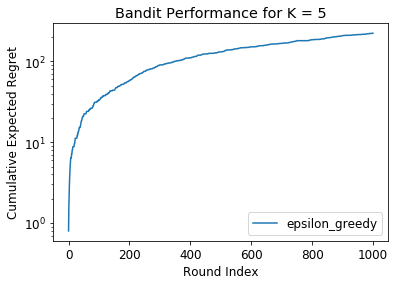

[0.1 0.1 0.1 0.1 0.9]
Percentage of simulations that chose the best arm [0.722]


In [ ]:
# RUN EPSILON GREEDY with epsilon = 0.5
K = 5
counts = np.ones((K, 2))
epsilon=0.5
n_simulations = 1000
#epsilon_greedy(counts)
algorithms = [epsilon_greedy]
ctr, algo_opt_arm_percentage, algo_cum_regret, fig = run_experiments(K, n_simulations, algorithms)
print('Results when epsilon = 0.5')
plt.show()
print(ctr)
print('% of simulations that chose the best arm:', algo_opt_arm_percentage)

Results when epsilon = 0.1


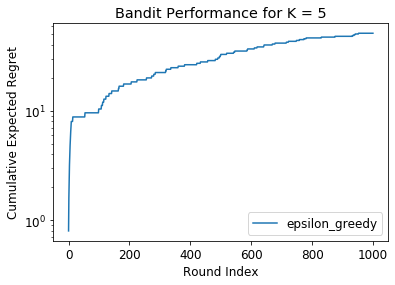

[0.1 0.1 0.1 0.1 0.9]
% of simulations that chose the best arm [0.936]


In [ ]:
# RUN EPSILON GREEDY with epsilon = 0.1
K = 5
counts = np.ones((K, 2))
epsilon=0.1
n_simulations = 1000
algorithms = [epsilon_greedy]
ctr, algo_opt_arm_percentage, algo_cum_regret, fig = run_experiments(K, n_simulations, algorithms)
print('Results when epsilon = 0.1')
plt.show()
print(ctr)
print('% of simulations that chose the best arm', algo_opt_arm_percentage)

UCB algorithm


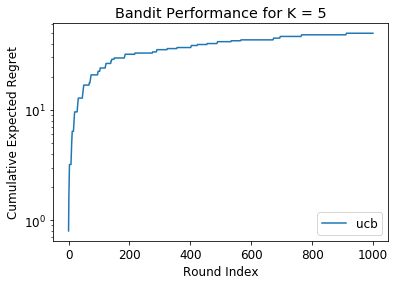

[0.1 0.1 0.1 0.1 0.9]
% of simulations that chose the best arm [0.938]


In [ ]:
# RUNNING UCB 
K = 5
n_simulations = 1000
algorithms = [ucb]
ctr, algo_opt_arm_percentage, algo_cum_regret, fig = run_experiments(K, n_simulations, algorithms)
print('UCB algorithm')
plt.show()
print(ctr)
print('% of simulations that chose the best arm', algo_opt_arm_percentage)

Thompson Sampling algorithm


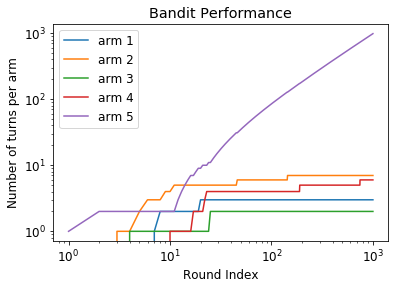

In [ ]:
# RUNNING THOMPSON SAMPLING
T = 1000
ctr = np.array([0.1,0.1,0.1,0.1,0.9])
ctr, trials, success, alphas, betas = experiment(T=T, ctr=ctr)
fig = experiment_plot(ctr, trials, success)
print('Thompson Sampling algorithm')
plt.show()

From our experiments, we observe that the algorithms converged and that the UCB algorithm seems to be performing better than the greedy algorithm when epsilon is either 0.5 or 0.1 & when round index =1000. As we wanted the expected comulative regret to be the lowest. 

Code adapted from: 

https://github.com/ankonzoid/LearningX/tree/master/classical_RL/multiarmed_bandit and https://gdmarmerola.github.io/ts-for-bernoulli-bandit/

### 3. Reinforcement Learning (3pt)

We will use the MIT licensed [code](https://github.com/seungeunrho/minimalRL) to do sensitivity analysis of DQN for the cartpole environment from the `gym` [package](https://gym.openai.com/). You should clone it as needed.

 -  Describe the state, actions, transitions and rewards for the cartpole environment using the gym package documentation.
 -  Describe the Q-network used in `dqn.py`. What are the layers and what are the outputs?
 -  Run the default DQN configuration for cartpole in `dqn.py` and plot the (25,50,75)-percentile reward performance curves over multiple simulations/runs.
 -  Change the epsilon value (for exploration) to fixed values $\{0.01,0.1\}$ and plot its impact on learning. Provide an interpretation of the trend observed.
 -  Change the buffer\_limit (of the experience replay buffer) to $\{5000,10000,25000\}$ and plot its impact on learning. Provide an interpretation of the trend observed.
 -  Change gamma (for discounting) to $\{0.75,0.9\}$ and discuss its impact on on learning. Provide an interpretation of the trend observed.

state :  consists of four observables corresponding to position and movements. Cart Position , Cart Velocity, Pole Angle, Pole Velocity At Tip

actions : 0 or 1, pushing the car left or right

transitions: give us the next state s’

rewards: comes from taking action a in state s at time t. A reward of +1 is provided for every timestep that the pole remains upright.  

The Qnet class has 3 layers that are linear transformations. The first layer, self.fc1, has 4 in_features and 128 out features. The second layer, self.fc2, has 128 in_features and 128 out features. The last one, self.fc3, has 128 in_features and 2 out features. 

In [ ]:
import gym
import collections
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

n_episode :20, score : 71.8, n_buffer : 1435, eps : 7.9%
n_episode :40, score : 35.0, n_buffer : 2135, eps : 7.8%
n_episode :60, score : 10.3, n_buffer : 2342, eps : 7.7%
n_episode :80, score : 11.1, n_buffer : 2563, eps : 7.6%
n_episode :100, score : 12.8, n_buffer : 2820, eps : 7.5%
n_episode :120, score : 19.2, n_buffer : 3204, eps : 7.4%
n_episode :140, score : 42.8, n_buffer : 4059, eps : 7.3%
n_episode :160, score : 65.0, n_buffer : 5360, eps : 7.2%
n_episode :180, score : 82.8, n_buffer : 7015, eps : 7.1%
n_episode :200, score : 148.3, n_buffer : 9981, eps : 7.0%
n_episode :220, score : 164.2, n_buffer : 13265, eps : 6.9%
n_episode :240, score : 173.2, n_buffer : 16729, eps : 6.8%
n_episode :260, score : 153.9, n_buffer : 19808, eps : 6.7%
n_episode :280, score : 228.8, n_buffer : 24384, eps : 6.6%
n_episode :300, score : 161.6, n_buffer : 27615, eps : 6.5%
n_episode :320, score : 181.8, n_buffer : 31250, eps : 6.4%
n_episode :340, score : 186.3, n_buffer : 34977, eps : 6.3%
n_e

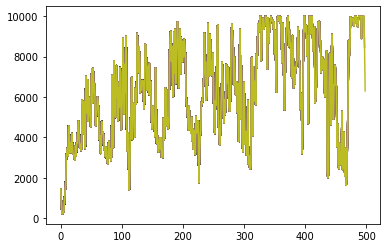

In [ ]:
#DEFAULT DQN CONFIGURATION

#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 32

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()
            
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def main():
    env = gym.make('CartPole-v1')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    total_score = []
    list_epsilon = []

    for n_epi in range(10000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)      
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            score += r
            if done:
                break
            
        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                            n_epi, score/print_interval, memory.size(), epsilon*100))
            
            total_score.append(score)
            list_epsilon.append(epsilon)
            plt.plot(total_score)
            
            score = 0.0
    env.close()

if __name__ == '__main__':
    main()
    plt.show()

n_episode :20, score : 10.4, n_buffer : 209, eps : 9.9%
n_episode :40, score : 10.1, n_buffer : 410, eps : 9.8%
n_episode :60, score : 10.0, n_buffer : 610, eps : 9.7%
n_episode :80, score : 9.6, n_buffer : 802, eps : 9.6%
n_episode :100, score : 9.8, n_buffer : 997, eps : 9.5%
n_episode :120, score : 9.6, n_buffer : 1189, eps : 9.4%
n_episode :140, score : 9.8, n_buffer : 1386, eps : 9.3%
n_episode :160, score : 9.8, n_buffer : 1582, eps : 9.2%
n_episode :180, score : 9.2, n_buffer : 1766, eps : 9.1%
n_episode :200, score : 9.8, n_buffer : 1963, eps : 9.0%
n_episode :220, score : 28.6, n_buffer : 2535, eps : 8.9%
n_episode :240, score : 38.5, n_buffer : 3305, eps : 8.8%
n_episode :260, score : 66.2, n_buffer : 4630, eps : 8.7%
n_episode :280, score : 50.0, n_buffer : 5630, eps : 8.6%
n_episode :300, score : 71.5, n_buffer : 7059, eps : 8.5%
n_episode :320, score : 127.5, n_buffer : 9608, eps : 8.4%
n_episode :340, score : 176.9, n_buffer : 13147, eps : 8.3%
n_episode :360, score : 208

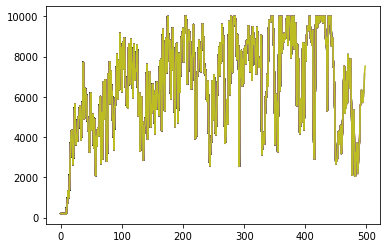

In [ ]:
#NEW EPSILON VALUE to fixed values  {0.01,0.1}  and plot its impact on learning. 

#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 32

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()
            
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def main():
    env = gym.make('CartPole-v1')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    total_score = []
    list_epsilon = []

    for n_epi in range(10000):
        epsilon = max(0.01, 0.1 - 0.01*(n_epi/200)) #Linear annealing from {0.01,0.1}
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)      
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            score += r
            if done:
                break
            
        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                            n_epi, score/print_interval, memory.size(), epsilon*100))
            
            total_score.append(score)
            list_epsilon.append(epsilon)
            plt.plot(total_score)
            
            score = 0.0
    env.close()

if __name__ == '__main__':
    main()
    plt.show()

When we change the value of epsilon to fixed values  {0.01, 0.1} we can see that the learning is better at the beginning. 

n_episode :20, score : 10.7, n_buffer : 213, eps : 7.9%
n_episode :40, score : 10.1, n_buffer : 415, eps : 7.8%
n_episode :60, score : 9.8, n_buffer : 611, eps : 7.7%
n_episode :80, score : 10.1, n_buffer : 813, eps : 7.6%
n_episode :100, score : 9.9, n_buffer : 1012, eps : 7.5%
n_episode :120, score : 9.6, n_buffer : 1203, eps : 7.4%
n_episode :140, score : 9.6, n_buffer : 1395, eps : 7.3%
n_episode :160, score : 9.2, n_buffer : 1579, eps : 7.2%
n_episode :180, score : 9.3, n_buffer : 1765, eps : 7.1%
n_episode :200, score : 10.2, n_buffer : 1968, eps : 7.0%
n_episode :220, score : 17.8, n_buffer : 2323, eps : 6.9%
n_episode :240, score : 20.1, n_buffer : 2726, eps : 6.8%
n_episode :260, score : 9.6, n_buffer : 2917, eps : 6.7%
n_episode :280, score : 11.9, n_buffer : 3155, eps : 6.6%
n_episode :300, score : 14.2, n_buffer : 3438, eps : 6.5%
n_episode :320, score : 32.7, n_buffer : 4092, eps : 6.4%
n_episode :340, score : 84.2, n_buffer : 5000, eps : 6.3%
n_episode :360, score : 201.1

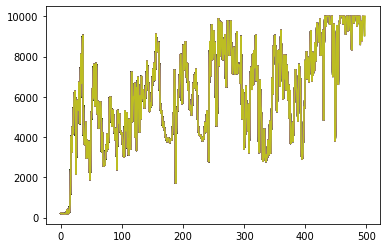

In [ ]:
#BUFFER LIMIT changed to from 50000 to 5000

#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 5000
batch_size    = 32

if __name__ == '__main__':
    main()
    plt.show()

when we change the buffer limit value from 50000 to 5000, we can see that the learning is better and the score values do not fluctuate as much. 

n_episode :20, score : 11.4, n_buffer : 228, eps : 7.9%
n_episode :40, score : 11.1, n_buffer : 450, eps : 7.8%
n_episode :60, score : 11.3, n_buffer : 677, eps : 7.7%
n_episode :80, score : 11.7, n_buffer : 910, eps : 7.6%
n_episode :100, score : 11.1, n_buffer : 1131, eps : 7.5%
n_episode :120, score : 11.2, n_buffer : 1354, eps : 7.4%
n_episode :140, score : 11.4, n_buffer : 1582, eps : 7.3%
n_episode :160, score : 11.9, n_buffer : 1821, eps : 7.2%
n_episode :180, score : 11.1, n_buffer : 2043, eps : 7.1%
n_episode :200, score : 14.8, n_buffer : 2340, eps : 7.0%
n_episode :220, score : 12.2, n_buffer : 2583, eps : 6.9%
n_episode :240, score : 15.8, n_buffer : 2898, eps : 6.8%
n_episode :260, score : 18.4, n_buffer : 3267, eps : 6.7%
n_episode :280, score : 40.5, n_buffer : 4077, eps : 6.6%
n_episode :300, score : 118.8, n_buffer : 6452, eps : 6.5%
n_episode :320, score : 181.8, n_buffer : 10000, eps : 6.4%
n_episode :340, score : 143.1, n_buffer : 10000, eps : 6.3%
n_episode :360, s

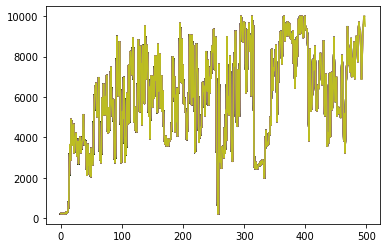

In [14]:
#BUFFER LIMIT changed to from 50000 to 10000

#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 10000
batch_size    = 32

class ReplayBuffer():
    def __init__(self):
        self.buffer = collections.deque(maxlen=buffer_limit)
    
    def put(self, transition):
        self.buffer.append(transition)
    
    def sample(self, n):
        mini_batch = random.sample(self.buffer, n)
        s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
        
        for transition in mini_batch:
            s, a, r, s_prime, done_mask = transition
            s_lst.append(s)
            a_lst.append([a])
            r_lst.append([r])
            s_prime_lst.append(s_prime)
            done_mask_lst.append([done_mask])

        return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
               torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
               torch.tensor(done_mask_lst)
    
    def size(self):
        return len(self.buffer)

class Qnet(nn.Module):
    def __init__(self):
        super(Qnet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
      
    def sample_action(self, obs, epsilon):
        out = self.forward(obs)
        coin = random.random()
        if coin < epsilon:
            return random.randint(0,1)
        else : 
            return out.argmax().item()
            
def train(q, q_target, memory, optimizer):
    for i in range(10):
        s,a,r,s_prime,done_mask = memory.sample(batch_size)

        q_out = q(s)
        q_a = q_out.gather(1,a)
        max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
        target = r + gamma * max_q_prime * done_mask
        loss = F.smooth_l1_loss(q_a, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def main():
    env = gym.make('CartPole-v1')
    q = Qnet()
    q_target = Qnet()
    q_target.load_state_dict(q.state_dict())
    memory = ReplayBuffer()

    print_interval = 20
    score = 0.0  
    optimizer = optim.Adam(q.parameters(), lr=learning_rate)
    total_score = []
    list_epsilon = []

    for n_epi in range(10000):
        epsilon = max(0.01, 0.08 - 0.01*(n_epi/200)) #Linear annealing from 8% to 1%
        s = env.reset()
        done = False

        while not done:
            a = q.sample_action(torch.from_numpy(s).float(), epsilon)      
            s_prime, r, done, info = env.step(a)
            done_mask = 0.0 if done else 1.0
            memory.put((s,a,r/100.0,s_prime, done_mask))
            s = s_prime

            score += r
            if done:
                break
            
        if memory.size()>2000:
            train(q, q_target, memory, optimizer)

        if n_epi%print_interval==0 and n_epi!=0:
            q_target.load_state_dict(q.state_dict())
            print("n_episode :{}, score : {:.1f}, n_buffer : {}, eps : {:.1f}%".format(
                                                            n_epi, score/print_interval, memory.size(), epsilon*100))
            
            total_score.append(score)
            list_epsilon.append(epsilon)
            plt.plot(total_score)
            
            score = 0.0
    env.close()

if __name__ == '__main__':
    main()
    plt.show()

when we change the buffer limit value from 50000 to 10000, we can see that the scores are smaller. 

n_episode :20, score : 9.9, n_buffer : 199, eps : 7.9%
n_episode :40, score : 10.0, n_buffer : 399, eps : 7.8%
n_episode :60, score : 9.8, n_buffer : 595, eps : 7.7%
n_episode :80, score : 10.2, n_buffer : 800, eps : 7.6%
n_episode :100, score : 9.6, n_buffer : 991, eps : 7.5%
n_episode :120, score : 9.6, n_buffer : 1183, eps : 7.4%
n_episode :140, score : 10.0, n_buffer : 1383, eps : 7.3%
n_episode :160, score : 10.2, n_buffer : 1588, eps : 7.2%
n_episode :180, score : 10.1, n_buffer : 1790, eps : 7.1%
n_episode :200, score : 9.7, n_buffer : 1983, eps : 7.0%
n_episode :220, score : 16.1, n_buffer : 2305, eps : 6.9%
n_episode :240, score : 17.6, n_buffer : 2656, eps : 6.8%
n_episode :260, score : 26.9, n_buffer : 3195, eps : 6.7%
n_episode :280, score : 44.1, n_buffer : 4078, eps : 6.6%
n_episode :300, score : 81.3, n_buffer : 5705, eps : 6.5%
n_episode :320, score : 112.0, n_buffer : 7945, eps : 6.4%
n_episode :340, score : 186.2, n_buffer : 11668, eps : 6.3%
n_episode :360, score : 8

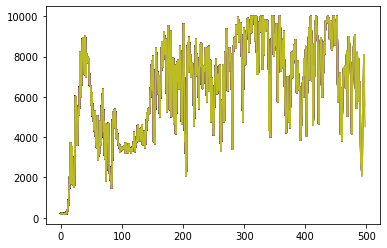

In [15]:
#BUFFER LIMIT changed to from 50000 to 25000

#Hyperparameters
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 25000
batch_size    = 32

if __name__ == '__main__':
    main()
    plt.show()

when we change the buffer limit value from 50000 to 25000, we can also see that the scores are smaller in this case. 

n_episode :20, score : 81.8, n_buffer : 1636, eps : 7.9%
n_episode :40, score : 35.5, n_buffer : 2347, eps : 7.8%
n_episode :60, score : 41.5, n_buffer : 3177, eps : 7.7%
n_episode :80, score : 39.1, n_buffer : 3960, eps : 7.6%
n_episode :100, score : 42.0, n_buffer : 4801, eps : 7.5%
n_episode :120, score : 47.9, n_buffer : 5759, eps : 7.4%
n_episode :140, score : 26.4, n_buffer : 6286, eps : 7.3%
n_episode :160, score : 60.6, n_buffer : 7498, eps : 7.2%
n_episode :180, score : 28.1, n_buffer : 8060, eps : 7.1%
n_episode :200, score : 38.8, n_buffer : 8836, eps : 7.0%
n_episode :220, score : 27.8, n_buffer : 9392, eps : 6.9%
n_episode :240, score : 48.2, n_buffer : 10357, eps : 6.8%
n_episode :260, score : 80.2, n_buffer : 11960, eps : 6.7%
n_episode :280, score : 94.5, n_buffer : 13850, eps : 6.6%
n_episode :300, score : 67.8, n_buffer : 15207, eps : 6.5%
n_episode :320, score : 78.0, n_buffer : 16766, eps : 6.4%
n_episode :340, score : 103.7, n_buffer : 18839, eps : 6.3%
n_episode :

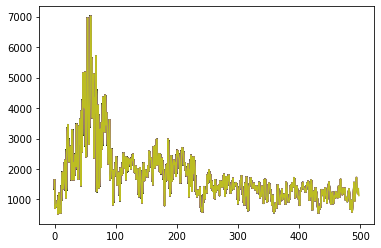

In [16]:
#Change gamma from 0.98 to 0.75

#Hyperparameters
learning_rate = 0.0005
gamma         = 0.75
buffer_limit  = 50000
batch_size    = 32

if __name__ == '__main__':
    main()
    plt.show()

When we change the gamma from 0.98 to 0.75, we can see the learning decreases significantly.

n_episode :20, score : 10.8, n_buffer : 215, eps : 7.9%
n_episode :40, score : 9.6, n_buffer : 406, eps : 7.8%
n_episode :60, score : 9.4, n_buffer : 594, eps : 7.7%
n_episode :80, score : 9.9, n_buffer : 793, eps : 7.6%
n_episode :100, score : 9.7, n_buffer : 986, eps : 7.5%
n_episode :120, score : 9.9, n_buffer : 1184, eps : 7.4%
n_episode :140, score : 10.1, n_buffer : 1386, eps : 7.3%
n_episode :160, score : 9.8, n_buffer : 1583, eps : 7.2%
n_episode :180, score : 9.9, n_buffer : 1781, eps : 7.1%
n_episode :200, score : 9.6, n_buffer : 1972, eps : 7.0%
n_episode :220, score : 10.3, n_buffer : 2179, eps : 6.9%
n_episode :240, score : 10.7, n_buffer : 2393, eps : 6.8%
n_episode :260, score : 10.3, n_buffer : 2599, eps : 6.7%
n_episode :280, score : 11.6, n_buffer : 2830, eps : 6.6%
n_episode :300, score : 13.2, n_buffer : 3095, eps : 6.5%
n_episode :320, score : 27.6, n_buffer : 3648, eps : 6.4%
n_episode :340, score : 49.8, n_buffer : 4644, eps : 6.3%
n_episode :360, score : 141.2, 

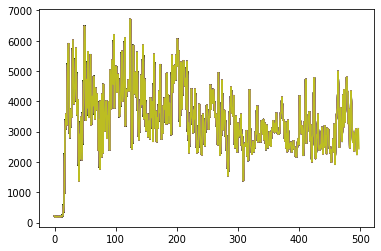

In [18]:
#Change gamma from 0.98 to 0.9  

#Hyperparameters
learning_rate = 0.0005
gamma         = 0.9
buffer_limit  = 50000
batch_size    = 32

if __name__ == '__main__':
    main()
    plt.show()

When we change the gamma value from 0.98 to 0.75, we observe the scores increase greatly compared to when the gamma was 0.75. Still the gamma that performs the best is the 0.98